In [1]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GINConv, GAE, EdgeConv # SAGEConv
import torch_geometric.nn as gnn
from torch import  nn

from torch_geometric.loader import NeighborSampler
from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
import matplotlib.pyplot as plt
from torch import Tensor
from torch_sparse import SparseTensor
from typing import Union

In [2]:
import torch_geometric
import torch_scatter as scatter
import networkx as nx

def add_label_feature(x, y):
    y = y.clone()
    # All fraudulent nodes are temporarily considered as normal users to simulate the scenario of mining fraudulent users from normal users.
    y[y == 1] = 0
    y[y == -100] = 0
    y_one_hot = F.one_hot(y).squeeze()
    print(y_one_hot.shape, ' ', x.shape)
    return torch.cat((x, y_one_hot.unsqueeze(dim=1)), dim=1)


def add_label_counts(x, edge_index, y):
    y = y.clone().squeeze()
    background_nodes = torch.logical_or(y == 2, y == 3)
    foreground_nodes = torch.logical_and(y != 2, y != 3)
    y[background_nodes] = 1
    y[foreground_nodes] = 0

    row, col = edge_index
    a = F.one_hot(y[col])
    b = F.one_hot(y[row])
    temp = scatter.scatter(a, row, dim=0, dim_size=y.size(0), reduce="sum")
    temp += scatter.scatter(b, col, dim=0, dim_size=y.size(0), reduce="sum")

    return torch.cat([x, temp.to(x)], dim=1)

def add_feature_flag(x):
    feature_flag = torch.zeros_like(x[:, :17])
    feature_flag[x[:, :17] == -1] = 1
    x[x == -1] = 0
    return torch.cat((x, feature_flag), dim=1)

def add_degree_feature(x, edge_index):
    row, col = edge_index
    in_degree = torch_geometric.utils.degree(col, x.size(0), x.dtype)

    out_degree = torch_geometric.utils.degree(row, x.size(0), x.dtype)
    return torch.cat([x, in_degree.view(-1, 1), out_degree.view(-1, 1)], dim=1)


def aa_index(x, edge_index):
    graph = nx.Graph()
    graph.add_edges_from(edge_index.cpu().numpy().T)
    aa_index = {}

    for node in graph.nodes():
        aa_index[node] = 0.0
        neighbors = set(graph.neighbors(node))

        for neighbor in neighbors:
            common_neighbors = set(graph.neighbors(neighbor)).intersection(neighbors)
            if len(common_neighbors) > 0:
                aa_index[node] += 1 / np.log(len(common_neighbors)) if len(common_neighbors) > 1 else 0
                
    aa_feature = np.array([aa_index[node] for node in graph.nodes()])
    aa_feature = aa_feature.reshape(-1, 1)
    x_with_aa = np.concatenate((x, aa_feature), axis=1)
    return x_with_aa


def cos_sim_sum(x, edge_index):
    row, col = edge_index
    sim = F.cosine_similarity(x[row], x[col])
    sim_sum = scatter.scatter(sim, row, dim=0, dim_size=x.size(0), reduce="sum")
    return torch.cat([x, torch.unsqueeze(sim_sum, dim=1)], dim=1)


def to_undirected(edge_index, edge_attr):
    row, col = edge_index
    row, col = torch.cat([row, col], dim=0), torch.cat([col, row], dim=0)
    edge_index = torch.stack([row, col], dim=0)

    edge_attr = torch.cat([edge_attr, edge_attr], dim=0)
    return edge_index, edge_attr


def data_process(data):
    edge_index, edge_attr = (
        data.edge_index,
        data.edge_attr,
    )

    x = data.x
    x = add_degree_feature(x, edge_index)
    x = cos_sim_sum(x, edge_index)
    # x = aa_index(x, edge_index)
    
    edge_index, edge_attr = to_undirected(
        edge_index, edge_attr
    )
    mask = edge_index[0] < edge_index[1]
    edge_index = edge_index[:, mask]
    edge_attr = edge_attr[mask]
    data.edge_index, data.edge_attr = to_undirected(
        edge_index, edge_attr
    )

    data.edge_direct = torch.ones(data.edge_attr.size(0), dtype=torch.long)
    data.edge_direct[: data.edge_attr.size(0) // 2] = 0
    
    # x = add_feature_flag(x)
    # x = add_label_counts(x, edge_index, data.y)
    # x = add_label_feature(x, data.y)
    
    data.x = x
    if data.y.dim() == 2:
        data.y = data.y.squeeze(1)
    return data

In [3]:
# with open("graphs_balance_data.pkl", "rb") as file:
with open("graphs_data2.pkl", "rb") as file:
    data = pickle.load(file)
    file.close()

In [4]:
print(data)

Data(x=[579157, 29], edge_index=[2, 167559], edge_attr=[167559], y=[579157, 1], train_mask=[231662], valid_mask=[154442], test_mask=[193053])


In [5]:
data = data_process(data)

In [6]:
print(data)

Data(x=[579157, 32], edge_index=[2, 335118], edge_attr=[335118], y=[579157], train_mask=[231662], valid_mask=[154442], test_mask=[193053], edge_direct=[335118])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}
data = data.to(device)
train_idx = split_idx['train'].to(device)

data.train_pos = train_idx[data.y[train_idx] == 1]
data.train_neg = train_idx[data.y[train_idx] == 0]

In [9]:
print(np.sum(data.y.cpu().numpy() == 1))
print(np.sum(data.y[data.train_mask].cpu().numpy() == 1))
print(np.sum(data.y[data.valid_mask].cpu().numpy() == 1))

4492
2671
1821


In [10]:
def creat_activation_layer(activation):
    if activation is None:
        return nn.Identity()
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "elu":
        return nn.ELU()
    else:
        raise ValueError("Unknown activation")

In [11]:
from typing import Tuple, Union
from torch import Tensor, nn
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import OptPairTensor

class SAGEConv(torch.nn.Module):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        normalize: bool = False,
        bias: bool = True,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.lin_m = Linear(in_channels[0], out_channels, bias=bias)
        self.lin_r = Linear(in_channels[1], out_channels, bias=bias)

    def reset_parameters(self):
        self.lin_r.reset_parameters()

        self.lin_m.reset_parameters()

    def forward(
        self,
        x: Union[Tensor, OptPairTensor],
        edge_index: Tensor,
        edge_attr: Tensor,
    ) -> Tensor:

        alpha = 0.5
        
        row, col = edge_index
        x_j = torch.cat([x[col], edge_attr], dim=1)
        x_j = scatter.scatter(x_j, row, dim=0, dim_size=x.size(0), reduce="sum")
        x_j = self.lin_m(x_j)
        x_i = self.lin_r(x)
        out = alpha * x_j + x_i

        if self.normalize:
            out = F.normalize(out, p=2.0, dim=-1)

        return out

In [12]:
class SAGE(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        edge_attr_channels=49,
        num_layers=3,
        dropout=0.3,
        bn=True,
        activation="elu",
    ):

        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        bn = nn.BatchNorm1d if bn else nn.Identity

        for i in range(num_layers):
            first_channels = in_channels if i == 0 else hidden_channels
            second_channels = 64 if i == num_layers - 1 else hidden_channels
            # second_channels = hidden_channels
            self.convs.append(
                SAGEConv(
                    (
                        first_channels + edge_attr_channels,
                        first_channels,
                    ),
                    second_channels,
                )
            )
            self.bns.append(bn(second_channels))
        
        self.regression = nn.Sequential(
            nn.Linear(64, 8),
            nn.Dropout(0.3),
            nn.ELU(),
            nn.Linear(8, out_channels),
        )
        
        self.dropout = nn.Dropout(dropout)
        self.activation = creat_activation_layer(activation)
        self.emb_type = nn.Embedding(12, edge_attr_channels)
        self.emb_direction = nn.Embedding(2, edge_attr_channels)
        self.reset_parameters()

    def reset_parameters(self):

        for conv in self.convs:
            conv.reset_parameters()

        for bn in self.bns:
            if not isinstance(bn, nn.Identity):
                bn.reset_parameters()

        nn.init.xavier_uniform_(self.emb_type.weight)

        nn.init.xavier_uniform_(self.emb_direction.weight)

    def forward(self, x, edge_index, edge_attr, edge_d):
        edge_attr = self.emb_type(edge_attr) + self.emb_direction(edge_d)
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_attr)
            x = self.bns[i](x)
            x = self.activation(x)
            x = self.dropout(x)
        
        x = self.regression(x)

        return x.log_softmax(dim=-1)

In [13]:
def random_walk_neighbor_sampling(graph, center_node, hop_size):
    # Perform random walk
    walk = [center_node]
    current_node = center_node
    for _ in range(hop_size):
        neighbors = list(graph.neighbors(current_node))
        if len(neighbors) == 0:
            break
        current_node = np.random.choice(neighbors)
        walk.append(current_node)

    # Extract subgraph
    subgraph = graph.subgraph(walk)
    
    # Map nodes to consecutive indices
    node_map = {node: i for i, node in enumerate(subgraph.nodes())}
    
    # Relabel nodes
    subgraph = nx.relabel_nodes(subgraph, node_map)
    
    # Get edge index
    edge_index = torch.tensor(list(subgraph.edges())).t().contiguous()

    # Create mask
    mask = torch.zeros(subgraph.number_of_nodes(), dtype=torch.bool)
    mask[torch.tensor(list(node_map.values()))] = True
    
    return subgraph, edge_index, node_map, mask

In [14]:
from torch_geometric.utils.subgraph import k_hop_subgraph

def train(model, data, optimizer):
    model.train()

    optimizer.zero_grad()
    neg_idx = data.train_neg[
        torch.randperm(data.train_neg.size(0))[: data.train_pos.size(0)]
    ]
    train_idx = torch.cat([data.train_pos, neg_idx], dim=0)

    
    nodeandneighbor, edge_index, node_map, mask = k_hop_subgraph(
        train_idx, 4, data.edge_index, relabel_nodes=True, num_nodes=data.x.size(0)
    )
    '''
    nodeandneighbor, edge_index, node_map, mask = random_walk_neighbor_sampling(
        train_idx, 3, data.edge_index
    )
    '''
    out = model(
        data.x[nodeandneighbor],
        edge_index,
        data.edge_attr[mask],
        data.edge_direct[mask],
    )
    loss = F.nll_loss(out[node_map], data.y[train_idx])
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), 2.0)

    optimizer.step()
    torch.cuda.empty_cache()
    return loss.item()

In [15]:
@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(
        data.x, data.edge_index, data.edge_attr, data.edge_direct,
    )

    y_pred = out.exp()
    return y_pred

In [16]:
lr = 0.001
l2 = 1e-5
epochs = 30

In [17]:
model = SAGE(
        in_channels=data.x.size(-1),
        hidden_channels=256,
        out_channels=2,
        num_layers=3,
        dropout=0.3,
        activation="elu",
        bn=True,
    ).to(device)

print(f'Model  initialized')

print(sum(p.numel() for p in model.parameters()))

model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.6)

train_auces = []
valid_auces = []

best_valid_auc = 0.0
best_model_path = 'best_model.pth' 

y_train, y_valid = data.y[data.train_mask].cpu().numpy(), data.y[data.valid_mask].cpu().numpy()

for epoch in range(1, epochs + 1):
    loss = train(model, data, optimizer)
    out = test(model, data)
    
    preds_train, preds_valid = out[data.train_mask], out[data.valid_mask]
    
    train_auc = roc_auc_score(y_train, preds_train[:, 1].cpu().numpy())
    valid_auc = roc_auc_score(y_valid, preds_valid[:, 1].cpu().numpy())
    
    train_auces.append(train_auc)
    valid_auces.append(valid_auc)
    
    if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
        torch.save(model.state_dict(), best_model_path)

    print(f'Epoch: {epoch:}, '
        f'Loss: {loss:.6f}, '
        f'Train: {train_auc:.6f}, '
        f'Valid: {valid_auc:.6f}')
    scheduler.step()

Model  initialized
211976
Epoch: 1, Loss: 0.711380, Train: 0.738066, Valid: 0.729344
Epoch: 2, Loss: 0.636328, Train: 0.746809, Valid: 0.736826
Epoch: 3, Loss: 0.610758, Train: 0.750632, Valid: 0.739065
Epoch: 4, Loss: 0.604053, Train: 0.753097, Valid: 0.740910
Epoch: 5, Loss: 0.603058, Train: 0.755278, Valid: 0.742440
Epoch: 6, Loss: 0.586440, Train: 0.757268, Valid: 0.743858
Epoch: 7, Loss: 0.593985, Train: 0.759566, Valid: 0.746063
Epoch: 8, Loss: 0.584132, Train: 0.762388, Valid: 0.748481
Epoch: 9, Loss: 0.576761, Train: 0.764859, Valid: 0.750712
Epoch: 10, Loss: 0.569316, Train: 0.766862, Valid: 0.752987
Epoch: 11, Loss: 0.576056, Train: 0.768821, Valid: 0.754870
Epoch: 12, Loss: 0.573149, Train: 0.770528, Valid: 0.756973
Epoch: 13, Loss: 0.567756, Train: 0.772122, Valid: 0.758744
Epoch: 14, Loss: 0.566354, Train: 0.773456, Valid: 0.760532
Epoch: 15, Loss: 0.565757, Train: 0.775028, Valid: 0.762464
Epoch: 16, Loss: 0.560784, Train: 0.776480, Valid: 0.764152
Epoch: 17, Loss: 0.5672

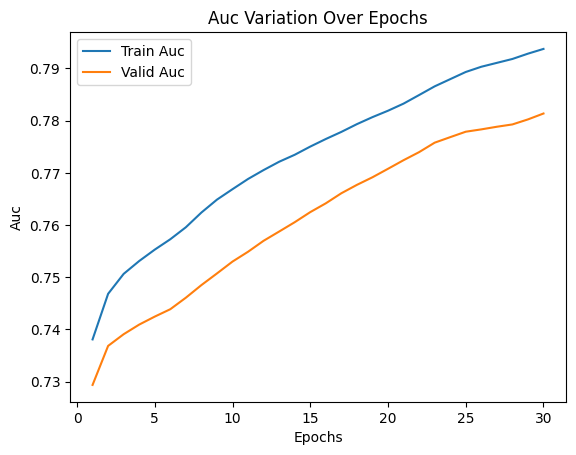

In [18]:
plt.plot(range(1, epochs + 1), train_auces, label='Train Auc')
plt.plot(range(1, epochs + 1), valid_auces, label='Valid Auc')


plt.title('Auc Variation Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Auc')

plt.legend()
plt.show()

In [19]:
model = SAGE(
        in_channels=data.x.size(-1),
        hidden_channels=256,
        out_channels=2,
        num_layers=3,
        dropout=0.3,
        activation="elu",
        bn=True,
    )
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

out = test(model, data)

# Extract predictions for training and validation sets
preds_train, preds_valid = out[data.train_mask].cpu().numpy(), out[data.valid_mask].cpu().numpy()
y_train, y_valid = data.y[data.train_mask].cpu().numpy(), data.y[data.valid_mask].cpu().numpy()

# Threshold predictions to obtain binary values (0 or 1)
threshold = 0.8
binary_preds_train = (preds_train[:, 1] > threshold).astype(int)
binary_preds_valid = (preds_valid[:, 1] > threshold).astype(int)

# Compute accuracy
accuracy_train = accuracy_score(y_train, binary_preds_train)
accuracy_valid = accuracy_score(y_valid, binary_preds_valid)

# Compute ROC AUC
train_auc = roc_auc_score(y_train, preds_train[:, 1])
valid_auc = roc_auc_score(y_valid, preds_valid[:, 1])

# Print the results
print('Train Accuracy:', accuracy_train)
print('Valid Accuracy:', accuracy_valid)
print('Train ROC AUC:', train_auc)
print('Valid ROC AUC:', valid_auc)
# 231662 228991
# 154442 152621
# MLP 0.8011

Train Accuracy: 0.9698310469563416
Valid Accuracy: 0.969075769544554
Train ROC AUC: 0.7937461254769576
Valid ROC AUC: 0.7813660878632137


In [20]:
print(np.sum(binary_preds_valid == 1), ' ', np.sum(y_valid == 1), ' ', np.sum(binary_preds_valid == y_valid), ' ', len(y_valid))

3229   1821   149666   154442


In [21]:
preds = out[data.test_mask].cpu().numpy()[:,1]
result_df = pd.DataFrame({'index': split_idx['test'], 'predict': preds})

result_df.to_csv('SAGE5.csv', index=False)